In [20]:
import pandas as pd
import numpy as np
import helper_functions as hf
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
import importlib
importlib.reload(hf)
import math
import copy


f = open("../data/AG_new/feces/otu_train_ibd.obj", "rb")
otu_train = pickle.load(f)
f.close()
otu_train.columns = otu_train.columns.map(str)

f = open("../data/AG_new/feces/otu_test_ibd.obj", "rb")
otu_test = pickle.load(f)
f.close()
otu_test.columns = otu_test.columns.map(str)

f = open("../data/AG_new/feces/qual_vecs_ibd_100.obj", "rb")
qual_vecs = pickle.load(f)
f.close()

f = open("../data/AG_new/feces/map_train_ibd.obj", "rb")
map_train = pickle.load(f)
f.close()

f = open("../data/AG_new/feces/map_test_ibd.obj", "rb")
map_test = pickle.load(f)
f.close()

In [21]:
importlib.reload(hf)
map_train, map_test = hf.makeMappingNumeric(map_train, map_test)

In [22]:
#Both of these functions need to take in non-normalized data

#Embed weighted by the number of times an organisms appears
taxa_occurrence = otu_train > 1
taxa_present = taxa_occurrence.sum(axis = 0) #total number of occurrences (0,1) of each taxa
taxa_present = taxa_present + 1

def embed_occurrence(otu, qual_vecs):
    taxa = [i for i in otu_use.columns.values if i in qual_vecs.index.values]
    qual_vecs_use = qual_vecs.loc[taxa]
    occurrence = np.matrix(otu > 1)
    taxa_present_use = np.array(taxa_present[otu_use.columns.values])
    inverse_freq_mat = pd.DataFrame(occurrence / taxa_present_use)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu_use.index.values)
    return(df)

#Embed weighted by the inverse of the overall normalized abundance of that organism in ALL samples
otu_tmp = hf.asinh(otu_train)
taxa_abundance = otu_tmp.sum(axis = 0) #total abundance of each taxa summed over samples

def embed_abundance(otu, qual_vecs):
    taxa = [i for i in otu.columns.values if i in qual_vecs.index.values]
    qual_vecs_use = qual_vecs.loc[taxa]
    otu_use = otu.loc[:, taxa]
    abundance = np.matrix(hf.asinh(otu_use))
    overall_taxa_abundance = np.array(taxa_abundance[otu_use.columns.values])
    inverse_freq_mat = pd.DataFrame(abundance / overall_taxa_abundance)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu_use.index.values)
    return(df)

def embed_average(otu, qual_vecs):
    taxa = [i for i in otu.columns.values if i in qual_vecs.index.values]
    qual_vecs_use = qual_vecs.loc[taxa]
    otu_use = otu.loc[:, taxa]
    df = pd.DataFrame(np.dot(hf.asinh(otu_use), qual_vecs_use), index = otu.index.values)
    return(df)

In [23]:
map_train_save = copy.deepcopy(map_train)
map_test_save = copy.deepcopy(map_test)

#Create input for ML alg including otu abundances and metadata
def setTarget(map_train, map_test, target = ""):
    y_train = [float(i) for i in map_train[target]]
    y_test = [float(i) for i in map_test[target]]
    map_train = map_train[target]
    map_test= map_test[target]
    return(map_train, map_test, y_train, y_test)

map_train, map_test, y_train, y_test = setTarget(map_train_save, map_test_save, target = "IBD")

In [13]:
f = open("../data/AG_new/feces/taxa_names.txt", "w")
for taxa in qual_vecs.index.values:
    f.write(taxa + '\n')
f.close()

In [24]:
X_train = preprocessing.scale(embed_average(otu_train, qual_vecs))
X_test = preprocessing.scale(embed_average(otu_test, qual_vecs))

[0.64919726371632,
 0.6172134580483039,
 0.6499511377914281,
 0.6363395225464191,
 0.6205779701242498]

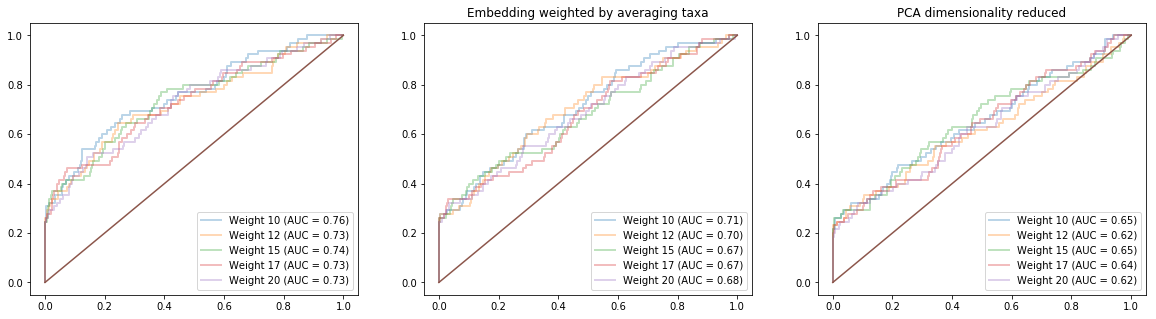

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)

#Normal
X_train = preprocessing.scale(hf.asinh(otu_train))
X_test = preprocessing.scale(hf.asinh(otu_test))
hf.predictIBD(X_train, y_train, X_test, y_test)

plt.subplot(1, 3, 2)
#Embed Average
X_train = preprocessing.scale(embed_average(otu_train, qual_vecs))
X_test = preprocessing.scale(embed_average(otu_test, qual_vecs))
hf.predictIBD(X_train, y_train, X_test, y_test, "Embedding weighted by averaging taxa")

plt.subplot(1, 3, 3)
#PCA
X_train, X_test = hf.getPCAReduced(otu_train, otu_test, components = 100)
hf.predictIBD(preprocessing.scale(X_train), y_train, preprocessing.scale(X_test), y_test, "PCA dimensionality reduced")

### Can we improve prediction at all by using biofiltered features?

### Repeat the above tests predicting gluten intolerance

In [8]:
map_train, map_test, y_train, y_test = setTarget(map_train_save, map_test_save, target = "GLUTEN")

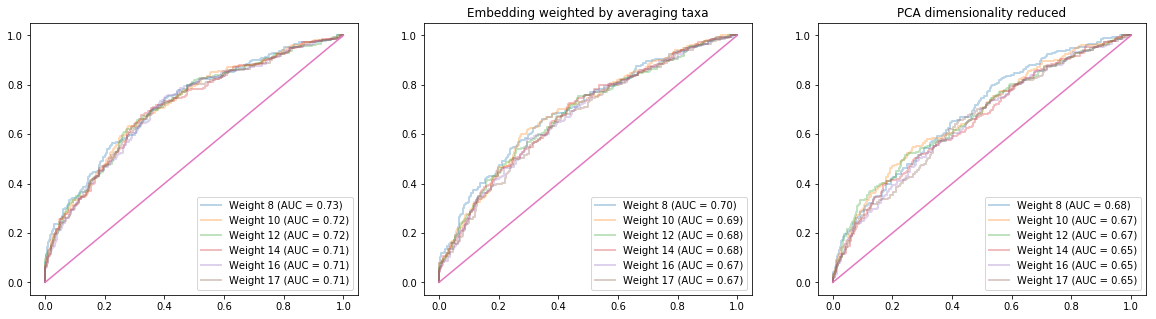

In [9]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)

#Normal
X_train = preprocessing.scale(hf.asinh(otu_train))
X_test = preprocessing.scale(hf.asinh(otu_test))
hf.predictIBD(X_train, y_train, X_test, y_test)

plt.subplot(1, 3, 2)
#Embed Average
X_train = preprocessing.scale(embed_average(otu_train, qual_vecs))
X_test = preprocessing.scale(embed_average(otu_test, qual_vecs))
hf.predictIBD(X_train, y_train, X_test, y_test, "Embedding weighted by averaging taxa")

plt.subplot(1, 3, 3)
#PCA
X_train, X_test = hf.getPCAReduced(X_train, X_test, components = 500)
hf.predictIBD(preprocessing.scale(X_train), y_train, preprocessing.scale(X_test), y_test, "PCA dimensionality reduced")

#### Problems: 
##### - Embeddings are very sensitive to sequencing depth (which dictates which taxa are "present" in any given environment)
##### - Challenge to interpret, even though they may be very meaningful
##### - Not sure how to integrate a dimension of time

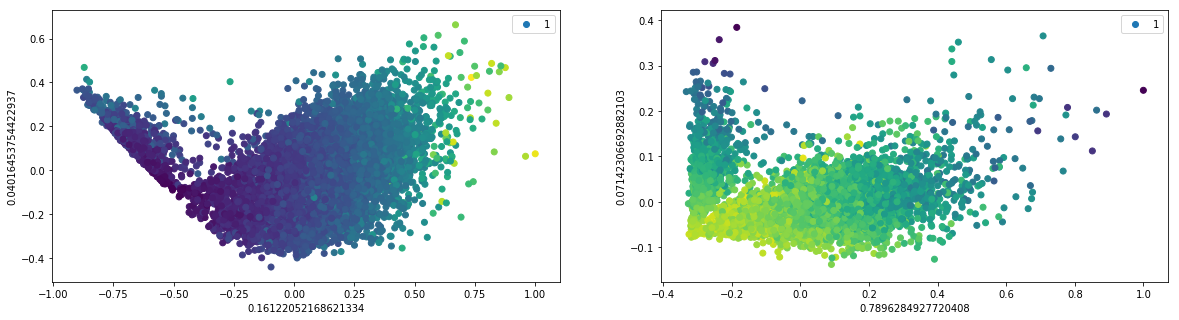

In [11]:
importlib.reload(hf)
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
hf.plotPCA(hf.asinh(otu_train),otu_raw = otu_train, components = 500)
plt.subplot(1, 2, 2)
hf.plotPCA(embed_average(otu_train, qual_vecs), otu_raw = otu_train, components = 500)


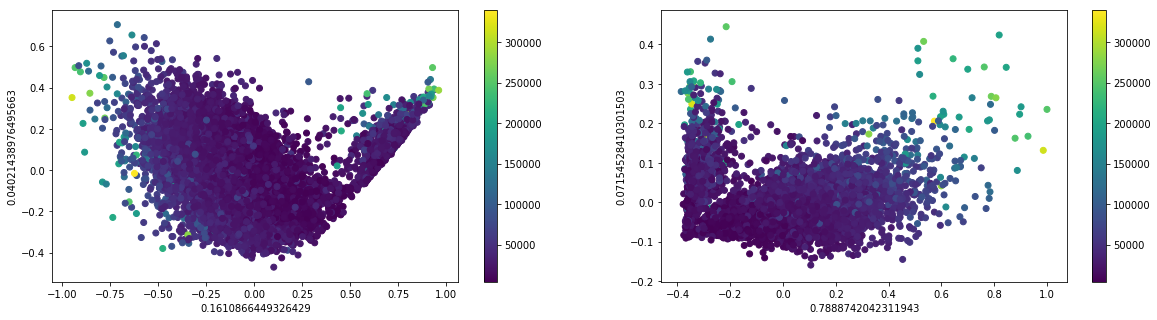

In [13]:
importlib.reload(hf)
plt.figure(figsize=(20,5))

otu_use = otu_train
sample_sums_table = otu_use.sum(axis = 1)
otu_use = otu_use.loc[sample_sums_table < 400000]

plt.subplot(1, 2, 1)
hf.plotPCA(hf.asinh(otu_use), otu_raw = otu_use, components = 500)
plt.subplot(1, 2, 2)
hf.plotPCA(embed_average(otu_use, qual_vecs), otu_raw = otu_use, components = 500)